In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from tqdm import tqdm
import seaborn as sns
import spacy
from scipy import stats
from pprint import pprint
from collections import defaultdict

tqdm.pandas()
nlp = spacy.load("en_core_web_sm")

In [3]:
# Load all generated captions
vistext_captions_df = pd.read_json("./vistext_eval/vistext_id_to_combined_captions.jsonl", orient='records', lines=True)
vistext_t5_captions_df = pd.read_json("./vistext_models_eval/vistext_t5_imageguided_captions.jsonl", orient='records', lines=True)
gallery_captions_df = pd.read_json("./matplotlib_gallery/mpl_gallery_combined_captions_shuffled.jsonl", orient='records', lines=True)
gallery_captions_df.rename(columns={'figure_id': 'image_id', 'gpt-4-turbo-L3-225': "gpt-4-turbo-L3",
                                    "gpt-4-turbo-alt-L3-225": "gpt-4-turbo-alt-L3"}, inplace=True)
# Load similarities to human captions
vistext_similarity_scores = np.load("./vistext_id_to_sim_scores.npy", allow_pickle=True).item()
# Convert similarity scores to dataframe
vistext_similarity_scores_df = []
for img_id in vistext_similarity_scores:
    sim_scores_dict = {"image_id": img_id}
    for cap_type, cap_sim_scores in vistext_similarity_scores[img_id].items():
        sim_scores_dict[cap_type + "_sim_scores"] = cap_sim_scores
    vistext_similarity_scores_df.append(sim_scores_dict)
vistext_similarity_scores_df = pd.DataFrame(vistext_similarity_scores_df)
# Load blipscores
vistext_blipscores = pd.read_json("./vistext_blipscores.jsonl", orient='records', lines=True)
gallery_blipscores = pd.read_json("./gallery_blipscores.jsonl", orient='records', lines=True)
vistext_blipscores.rename(columns={'figure_id': 'image_id'}, inplace=True)
gallery_blipscores.rename(columns={'figure_id': 'image_id', "gpt-4-turbo-L3-225-prob": "gpt-4-turbo-L3-prob",
                                   "gpt-4-turbo-alt-L3-225-prob": "gpt-4-turbo-alt-L3-prob",
                                   "gpt-4-turbo-L3-225-cos-sim": "gpt-4-turbo-L3-cos-sim",
                                   "gpt-4-turbo-alt-L3-225-cos-sim": "gpt-4-turbo-alt-L3-cos-sim"}, inplace=True)
# Load manually annotated errors
vistext_errors = pd.read_csv("./vistext_error_annotations.tsv", sep='\t', header=0)
gallery_errors = pd.read_csv("./gallery_error_annotations.tsv", sep='\t', header=0)
vistext_errors = vistext_errors.drop("Notes", axis=1)
vistext_errors.fillna("correct", inplace = True)
vistext_errors.rename(columns={'Image ID': 'image_id', 'Heuristic': "heuristic_errors",
                               "turbo L3": "gpt-4-turbo-L3_errors",
                               "turbo heuristic L3": "gpt-4-turbo-alt-L3_errors",
                               "turbo table L3": "gpt-4-turbo-table-L3_errors",
                               "turbo heuristic + table L3": "gpt-4-turbo-table-alt-L3_errors",
                               "Chart type": "chart_type"
                               }, inplace=True)
gallery_errors = gallery_errors.drop("Notes", axis=1)
gallery_errors.rename(columns={'Image ID': 'image_id', 'Heuristic': "heuristic_errors",
                               "turbo L3": "gpt-4-turbo-L3_errors",
                               "turbo heuristic L3": "gpt-4-turbo-alt-L3_errors",
                               "Chart type": "chart_type",
                               "Num subplots": "num_subplots"
                               }, inplace=True)
print(vistext_similarity_scores[9]['gpt-4-turbo-L3'].keys())
#print(vistext_errors.columns)
#print(gallery_errors.columns)

dict_keys(['rouge1_p', 'rouge1_r', 'rouge1_f1', 'rouge2_p', 'rouge2_r', 'rouge2_f1', 'rougeL_p', 'rougeL_r', 'rougeL_f1', 'rougeLsum_p', 'rougeLsum_r', 'rougeLsum_f1', 'bleu', 'chrf', 'bleurt', 'bertscore_p', 'bertscore_r', 'bertscore_f1'])


In [4]:
# Merge everything together
vistext_combined_stats_df = vistext_captions_df.copy()
gallery_combined_stats_df = gallery_captions_df.copy()
vistext_combined_stats_df = vistext_combined_stats_df.merge(right=vistext_t5_captions_df, on="image_id", how="outer")
vistext_combined_stats_df = vistext_combined_stats_df.merge(right=vistext_blipscores, on="image_id", how="outer")
vistext_combined_stats_df = vistext_combined_stats_df.merge(right=vistext_errors, on="image_id", how="outer")
vistext_combined_stats_df = vistext_combined_stats_df.merge(right=vistext_similarity_scores_df, on="image_id", how="outer")
gallery_combined_stats_df = gallery_combined_stats_df.merge(right=gallery_blipscores, on="image_id", how="outer")
gallery_combined_stats_df = gallery_combined_stats_df.merge(right=gallery_errors, on="image_id", how="outer")
vistext_combined_stats_df["num_subplots"] = 1
vistext_combined_stats_df["dataset"] = "vistext"
gallery_combined_stats_df["dataset"] = "gallery"
combined_stats_df = pd.concat([vistext_combined_stats_df, gallery_combined_stats_df])
combined_stats_df.to_json("./combined_stats.jsonl", orient='records', lines=True)
print(len(combined_stats_df), combined_stats_df.columns)

1084 Index(['image_id', 'human', 'heuristic', 'gpt-4-turbo-L4',
       'gpt-4-turbo-alt-L4', 'gpt-4-turbo-table-L4', 'gpt-4-turbo-L3',
       'gpt-4-turbo-alt-L3', 'gpt-4-turbo-table-L3',
       'gpt-4-turbo-table-alt-L3', 't5-imageguided-imageonly',
       't5-imageguided-datatable', 't5-imageguided-scenegraph', 'human-prob',
       'heuristic-prob', 'gpt-4-turbo-L4-prob', 'gpt-4-turbo-alt-L4-prob',
       'gpt-4-turbo-table-L4-prob', 'gpt-4-turbo-L3-prob',
       'gpt-4-turbo-alt-L3-prob', 'gpt-4-turbo-table-L3-prob',
       'gpt-4-turbo-table-alt-L3-prob', 'human-cos-sim', 'heuristic-cos-sim',
       'gpt-4-turbo-L4-cos-sim', 'gpt-4-turbo-alt-L4-cos-sim',
       'gpt-4-turbo-table-L4-cos-sim', 'gpt-4-turbo-L3-cos-sim',
       'gpt-4-turbo-alt-L3-cos-sim', 'gpt-4-turbo-table-L3-cos-sim',
       'gpt-4-turbo-table-alt-L3-cos-sim', 'heuristic_errors',
       'gpt-4-turbo-L3_errors', 'gpt-4-turbo-alt-L3_errors',
       'gpt-4-turbo-table-L3_errors', 'gpt-4-turbo-table-alt-L3_errors',
  

In [5]:
sim_L3_caption_types = ["heuristic", "gpt-4-turbo-L3", "gpt-4-turbo-alt-L3",
                        "gpt-4-turbo-table-L3", "gpt-4-turbo-table-alt-L3"]
sim_metric_to_arr = defaultdict(list)
sim_cap_lens = []
def get_sim_stat_arrs(row):
    for cap_type in sim_L3_caption_types:
        caption = row[cap_type]
        cap_sim_scores = row[f"{cap_type}_sim_scores"]
        if caption is not None and isinstance(cap_sim_scores, dict):
            if isinstance(caption, list) and len(caption) == 1:
                caption = caption[0]
            sim_cap_lens.append(len([token.text for token in nlp(caption)]))
            for metric_name, scores in cap_sim_scores.items():
                sim_metric_to_arr[metric_name].append(np.mean(scores))

combined_stats_df.progress_apply(get_sim_stat_arrs, axis=1)
sim_metric_to_arr["lens"] = sim_cap_lens
np.save("./caption_sim_metric_to_arr", sim_metric_to_arr)

100%|██████████| 1084/1084 [01:27<00:00, 12.32it/s]


Text(0.5, 0, 'Description length (tokens)')

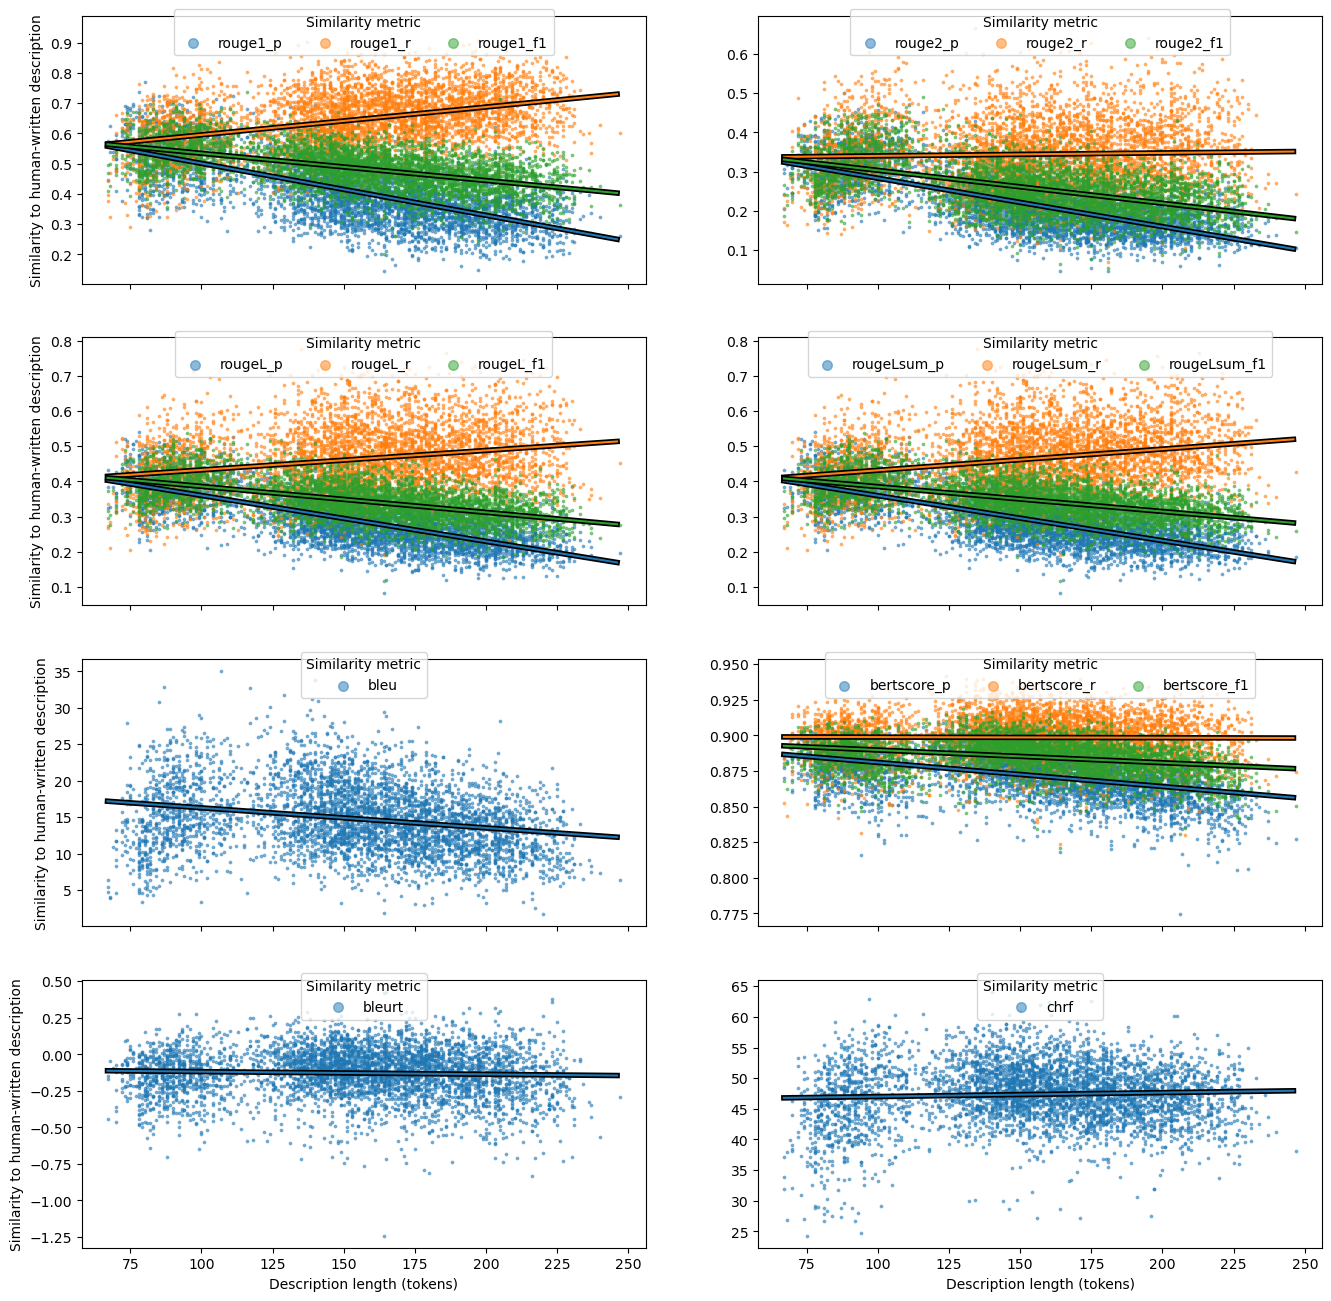

In [52]:
len_linear_fits = np.load("./len_linear_fits.npy", allow_pickle=True).item()
xs = np.array(list(range(np.min(sim_cap_lens), np.max(sim_cap_lens))))

metric_groups = ["rouge1", "rouge2", "rougeL", "rougeLsum", "bleu", "bertscore", "bleurt", "chrf"]

fig, axs = plt.subplots(ncols=2, nrows=(len(metric_groups) // 2), figsize=(16, 2*len(metric_groups)))
axs = axs.flatten()
for midx, mgroup in enumerate(metric_groups):
    for metric_name, cap_scores in sim_metric_to_arr.items():
        if metric_name.startswith(mgroup + "_") or metric_name == mgroup:
            axs[midx].scatter(sim_cap_lens, cap_scores, label=metric_name, s=3, alpha=0.5)
            metric_linear_fit = len_linear_fits["human_sim"][metric_name]
            axs[midx].plot(xs, metric_linear_fit.intercept + metric_linear_fit.slope * xs, path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])
            if midx not in [len(metric_groups) - 1, len(metric_groups) - 2]:
                axs[midx].set_xticklabels([])
    axs[midx].legend(title="Similarity metric", loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, markerscale=4)

for i in range(0, 8, 2):
    axs[i].set_ylabel("Similarity to human-written description")
axs[-1].set_xlabel("Description length (tokens)")
axs[-2].set_xlabel("Description length (tokens)")

In [8]:
sim_L3_caption_types = ["human", "heuristic", "gpt-4-turbo-L3", "gpt-4-turbo-alt-L3",
                        "gpt-4-turbo-table-L3", "gpt-4-turbo-table-alt-L3"]
blip_cap_lens = []
blip_probs = []
blip_cos_sims = []
def get_blip_stat_arrs(row):
    for cap_type in sim_L3_caption_types:
        if cap_type in row:
            captions = row[cap_type]
            if isinstance(captions, (str, list)):
                if isinstance(captions, str):
                    captions = [captions]
                cap_probs = row[f"{cap_type}-prob"]
                cap_cos_sims = row[f"{cap_type}-cos-sim"]
                if isinstance(cap_probs, float):
                    cap_probs = [cap_probs]
                if isinstance(cap_cos_sims, float):
                    cap_cos_sims = [cap_cos_sims]
                if isinstance(captions, str):
                    captions = [captions]
                for cap_idx, caption in enumerate(captions):
                    blip_cap_lens.append(len([token.text for token in nlp(caption)]))
                    blip_probs.append(cap_probs[cap_idx])
                    blip_cos_sims.append(cap_cos_sims[cap_idx])

combined_stats_df.progress_apply(get_blip_stat_arrs, axis=1)
np.save("./caption_blip_metric_to_arr", {"lens": blip_cap_lens, "probs": blip_probs,
                                         "cos_sims": blip_cos_sims})

100%|██████████| 1084/1084 [01:54<00:00,  9.50it/s]


In [45]:
len_linear_fits = np.load("./len_linear_fits.npy", allow_pickle=True).item()
xs = np.array(list(range(np.min(blip_cap_lens), np.max(blip_cap_lens))))
plt.gcf().set_size_inches(8, 8)
plt.scatter(blip_cap_lens, blip_probs, label="matching probability", s=6, alpha=0.5)
probs_fit = len_linear_fits["blipscores"]["probs"]
plt.plot(xs, probs_fit.intercept + probs_fit.slope * xs, path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])
plt.scatter(blip_cap_lens, blip_cos_sims, label="cosine similarity", s=6, alpha=0.5)
cos_sims_fit = len_linear_fits["blipscores"]["cos_sims"]
plt.plot(xs, cos_sims_fit.intercept + cos_sims_fit.slope * xs, path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])
plt.xlabel("Description length (tokens)")
plt.ylabel("Similarity to human-written description")
plt.legend(title="BLIP metric")

100%|██████████| 1084/1084 [00:00<00:00, 1918.49it/s]


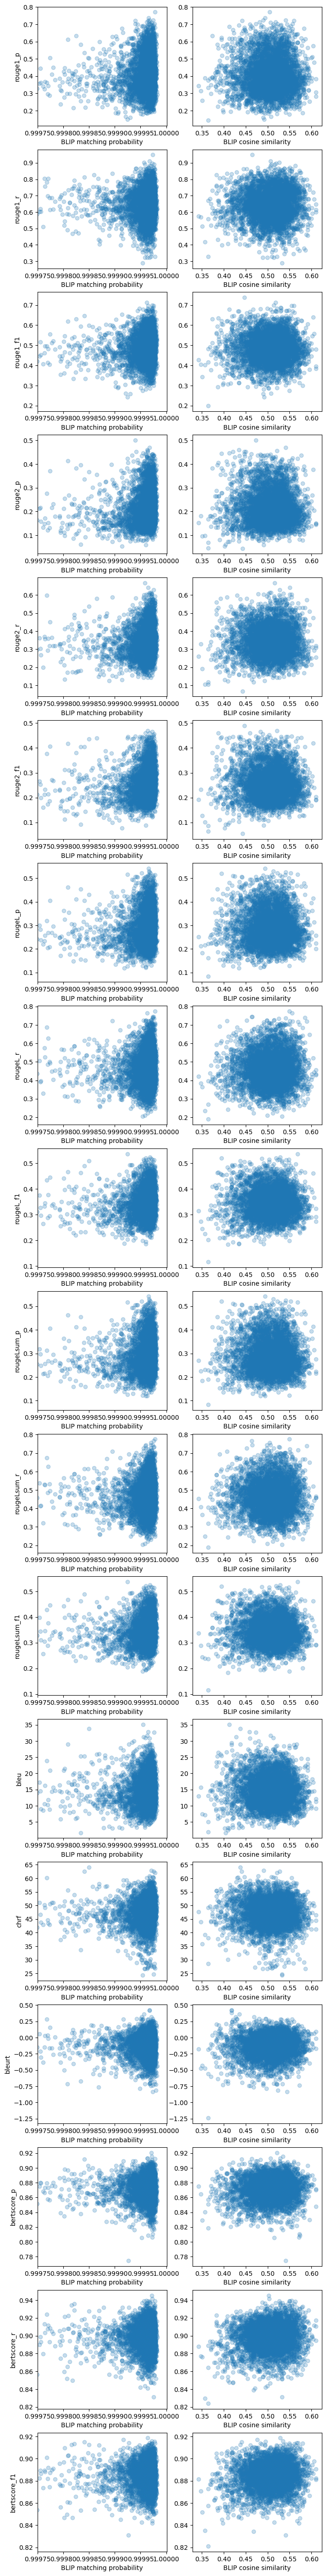

In [18]:
L3_caption_types = ["heuristic", "gpt-4-turbo-L3", "gpt-4-turbo-alt-L3",
                    "gpt-4-turbo-table-L3", "gpt-4-turbo-table-alt-L3"]
sim_metric_to_arr = defaultdict(list)
cur_blip_probs = []
cur_blip_cos_sims = []
def get_sim_blip_stat_arrs(row):
    for cap_type in L3_caption_types:
        caption = row[cap_type]
        cap_sim_scores = row[f"{cap_type}_sim_scores"]
        if caption is not None and isinstance(cap_sim_scores, dict):
            if isinstance(caption, list) and len(caption) == 1:
                caption = caption[0]
            cur_blip_probs.append(row[f"{cap_type}-prob"])
            cur_blip_cos_sims.append(row[f"{cap_type}-cos-sim"])
            for metric_name, scores in cap_sim_scores.items():
                sim_metric_to_arr[metric_name].append(np.mean(scores))

combined_stats_df.progress_apply(get_sim_blip_stat_arrs, axis=1)
fig, axs = plt.subplots(nrows=len(sim_metric_to_arr), ncols=2, figsize=(8, 4*len(sim_metric_to_arr)))
for i, (metric_name, scores) in enumerate(sim_metric_to_arr.items()):
    axs[i][0].scatter(cur_blip_probs, scores, alpha=0.25)
    axs[i][1].scatter(cur_blip_cos_sims, scores, alpha=0.25)
    axs[i][0].set_xlabel("BLIP matching probability")
    axs[i][0].set_ylabel(f"{metric_name}")
    axs[i][1].set_xlabel("BLIP cosine similarity")
    axs[i][0].set_xlim((0.99975, 1.000001))

In [63]:
L3_caption_types = ["heuristic", "gpt-4-turbo-L3", "gpt-4-turbo-alt-L3",
                    "gpt-4-turbo-table-L3", "gpt-4-turbo-table-alt-L3"]
vistext_chart_type_to_errors = {"line": defaultdict(int), "bar": defaultdict(int), "area": defaultdict(int)}
vistext_chart_type_to_human_sims = defaultdict(list)
vistext_chart_type_to_blip_probs = defaultdict(list)
vistext_chart_type_to_blip_sims = defaultdict(list)
vistext_chart_type_to_lens = defaultdict(list)
def get_chart_type_vistext_stat_arrs(row):
    for cap_type in L3_caption_types:
        if row["dataset"] == "vistext":
            caption = row[cap_type]
            cap_errors = row[f"{cap_type}_errors"]
            cap_blip_prob = row[f"{cap_type}-prob"]
            cap_blip_cos_sim = row[f"{cap_type}-cos-sim"]
            cap_human_sims = row[f"{cap_type}_sim_scores"]
            cap_chart_type = row["chart_type"]
            if caption is not None and isinstance(cap_errors, str):
                if isinstance(caption, list) and len(caption) == 1:
                    caption = caption[0]
                cap_len = len([token.text for token in nlp(caption)])
                vistext_chart_type_to_lens[cap_chart_type].append(cap_len)
                vistext_chart_type_to_blip_probs[cap_chart_type].append(cap_blip_prob)
                vistext_chart_type_to_blip_sims[cap_chart_type].append(cap_blip_cos_sim)
                vistext_chart_type_to_human_sims[cap_chart_type].append(cap_human_sims)
                for err_type in cap_errors.split(", "):
                    vistext_chart_type_to_errors[cap_chart_type][err_type] += 1
                vistext_chart_type_to_errors[cap_chart_type]["total_num"] += 1

combined_stats_df.progress_apply(get_chart_type_vistext_stat_arrs, axis=1)

100%|██████████| 1084/1084 [00:09<00:00, 110.10it/s]


0      None
1      None
2      None
3      None
4      None
       ... 
197    None
198    None
199    None
200    None
201    None
Length: 1084, dtype: object

In [97]:
norm_vistext_chart_type_to_errors = {}
for chart_type, chart_type_errs in vistext_chart_type_to_errors.items():
    norm_vistext_chart_type_to_errors[chart_type] = defaultdict(int)
    chart_type_num = chart_type_errs["total_num"]
    for err_type, num_errs in chart_type_errs.items():
        if err_type and err_type != "total_num":
            norm_vistext_chart_type_to_errors[chart_type][err_type] = num_errs / chart_type_num

chart_type_errs = pd.DataFrame(norm_vistext_chart_type_to_errors)
chart_type_errs["error_type"] = chart_type_errs.index
chart_type_errs = chart_type_errs.melt(id_vars=['error_type'], value_vars=['line', 'bar', 'area'],
                                       value_name='pct_with_err', var_name='chart_type')
sns.barplot(chart_type_errs, y="error_type", x="pct_with_err", hue="chart_type", orient="h",
            order=["correct", "chart type error", "trend error", "label error", "missing context",
                   "identity error", "deceptive error", "axis error", "value error", "cutoff",
                    "grammar error", "repetition", "unecessary context", "nonsense error"])
plt.title("VisText errors by chart type")

Text(0.5, 1.0, 'VisText errors by chart type')

In [99]:
L3_caption_types = ["heuristic", "gpt-4-turbo-L3", "gpt-4-turbo-alt-L3",
                    "gpt-4-turbo-table-L3", "gpt-4-turbo-table-alt-L3"]
gallery_chart_type_to_errors = {}
gallery_chart_type_to_blip_probs = defaultdict(list)
gallery_chart_type_to_blip_sims = defaultdict(list)
gallery_chart_type_to_lens = defaultdict(list)
def get_chart_type_gallery_stat_arrs(row):
    for cap_type in L3_caption_types:
        if row["dataset"] == "gallery":
            caption = row[cap_type]
            cap_errors = row[f"{cap_type}_errors"]
            cap_blip_prob = row[f"{cap_type}-prob"]
            cap_blip_cos_sim = row[f"{cap_type}-cos-sim"]
            cap_chart_type = row["chart_type"]
            if caption is not None and isinstance(cap_errors, str):
                if isinstance(caption, list) and len(caption) == 1:
                    caption = caption[0]
                if cap_chart_type not in gallery_chart_type_to_errors:
                    gallery_chart_type_to_errors[cap_chart_type] = defaultdict(int)
                cap_len = len([token.text for token in nlp(caption)])
                gallery_chart_type_to_lens[cap_chart_type].append(cap_len)
                gallery_chart_type_to_blip_probs[cap_chart_type].append(cap_blip_prob)
                gallery_chart_type_to_blip_sims[cap_chart_type].append(cap_blip_cos_sim)
                for err_type in cap_errors.split(", "):
                    gallery_chart_type_to_errors[cap_chart_type][err_type] += 1
                gallery_chart_type_to_errors[cap_chart_type]["total_num"] += 1

combined_stats_df.progress_apply(get_chart_type_gallery_stat_arrs, axis=1)

100%|██████████| 1084/1084 [00:04<00:00, 222.05it/s]


0      None
1      None
2      None
3      None
4      None
       ... 
197    None
198    None
199    None
200    None
201    None
Length: 1084, dtype: object

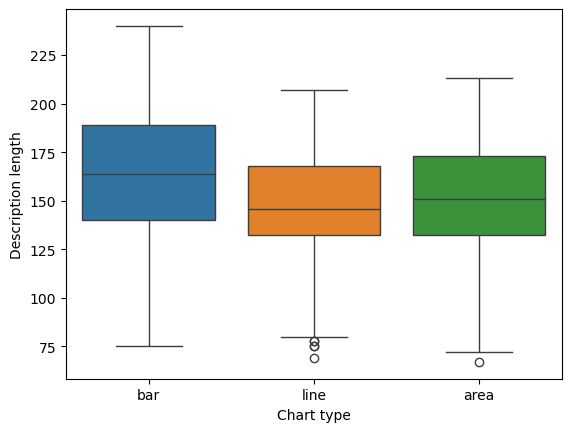

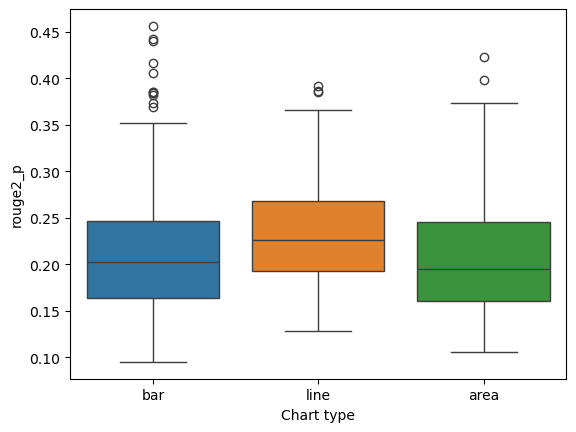

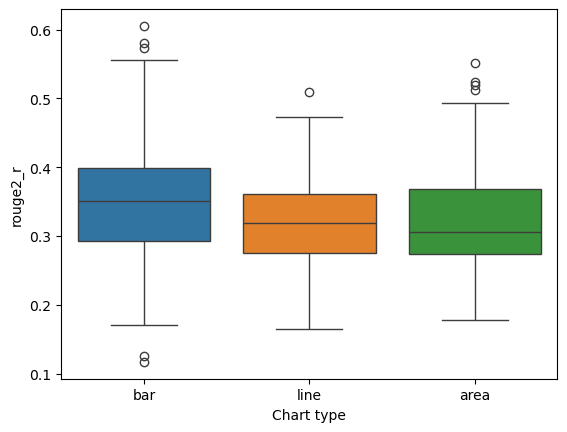

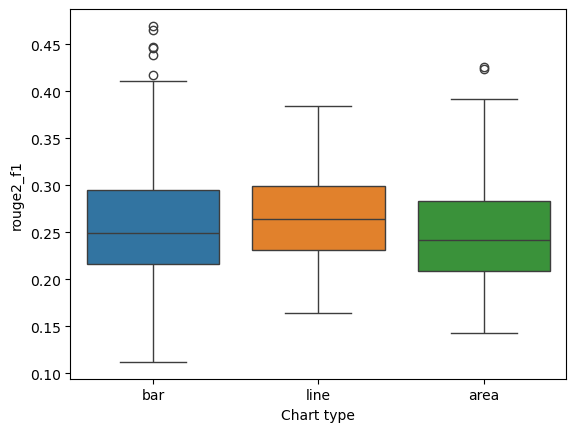

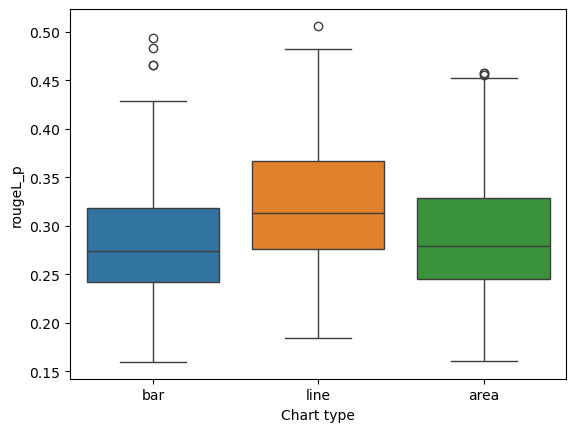

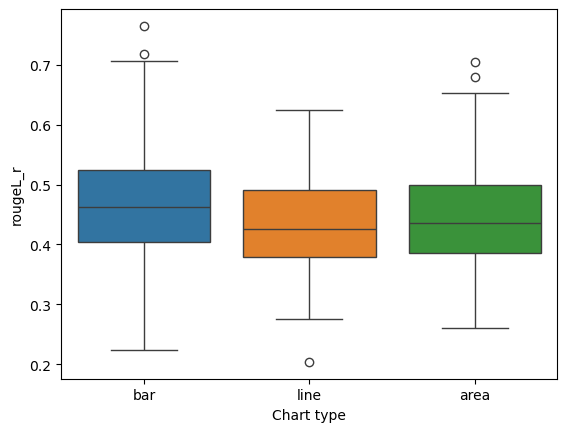

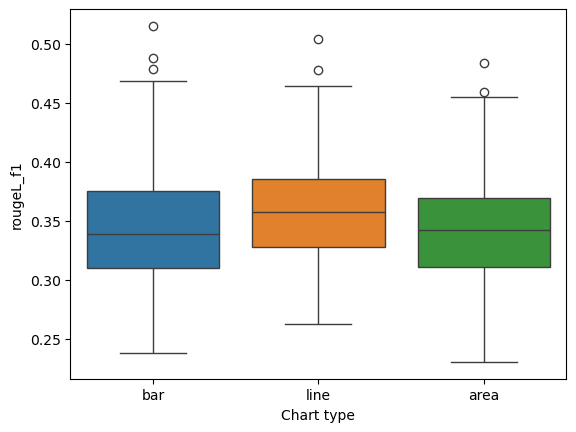

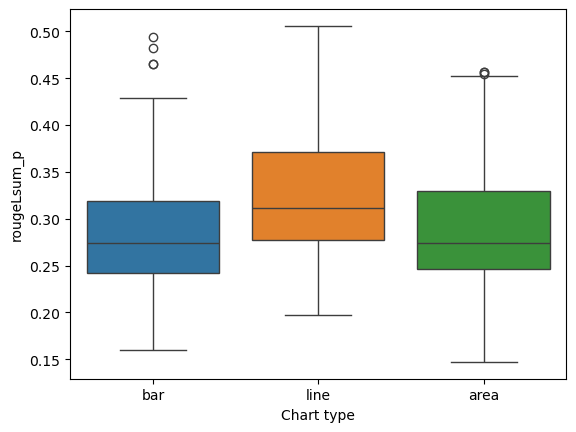

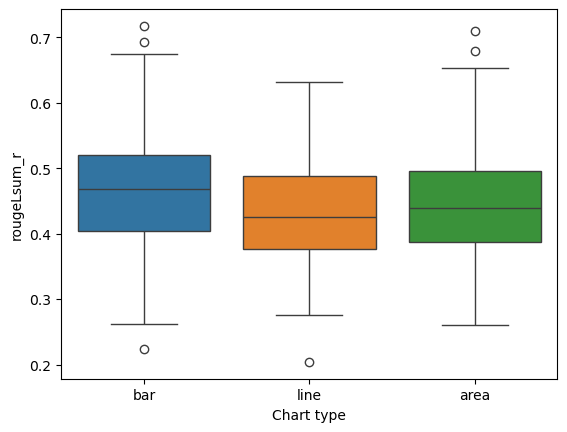

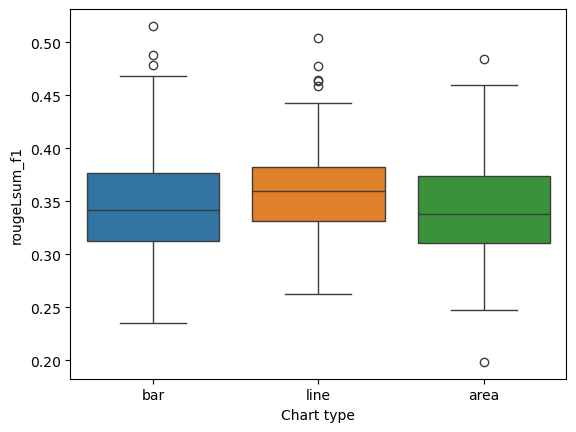

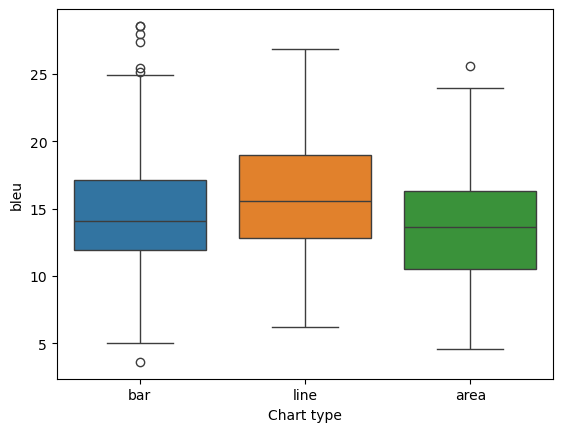

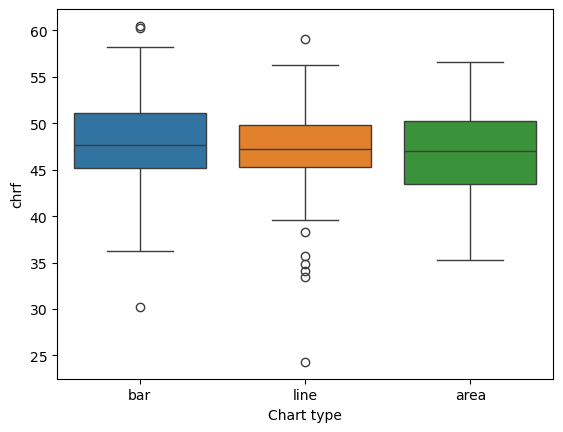

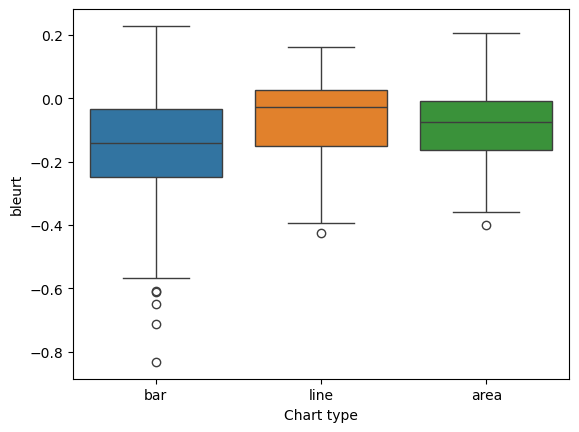

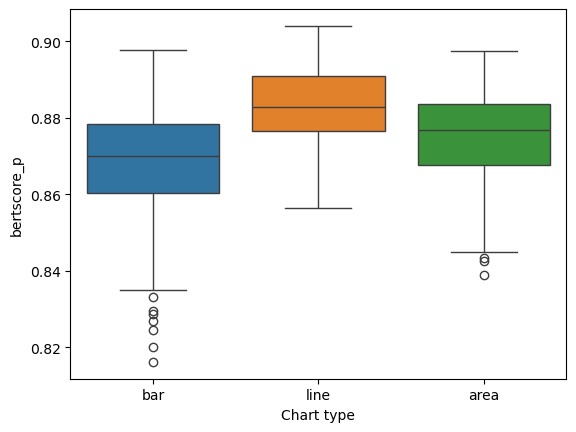

In [68]:
sns.boxplot(vistext_chart_type_to_lens)
plt.xlabel("Chart type")
plt.ylabel("Description length")
plt.show()

sns.boxplot(vistext_chart_type_to_blip_sims)
plt.xlabel("Chart type")
plt.ylabel("BLIP cosine similarity")
plt.show()

for sim_metric in vistext_chart_type_to_human_sims["line"][0].keys():
    sns.boxplot({ct: [np.mean(c[sim_metric]) for c in chs] for ct, chs in vistext_chart_type_to_human_sims.items()})
    plt.xlabel("Chart type")
    plt.ylabel(sim_metric)
    plt.show()

In [19]:
L3_caption_types = ["heuristic", "gpt-4-turbo-L3", "gpt-4-turbo-alt-L3",
                    "gpt-4-turbo-table-L3", "gpt-4-turbo-table-alt-L3"]
alt_lens_with_errs = defaultdict(list)
alt_blipscores_with_errs = defaultdict(list)
alt_human_sims_with_errs = defaultdict(list)
def get_sim_stat_arrs(row):
    for cap_type in L3_caption_types:
        caption = row[cap_type]
        cap_errors = row[f"{cap_type}_errors"]
        cap_blip_prob = row[f"{cap_type}-prob"]
        cap_blip_cos_sim = row[f"{cap_type}-cos-sim"]
        cap_human_sims = row[f"{cap_type}_sim_scores"]
        if caption is not None and isinstance(cap_errors, str):
            if isinstance(caption, list) and len(caption) == 1:
                caption = caption[0]
            cap_len = len([token.text for token in nlp(caption)])
            for err_type in cap_errors.split(", "):
                alt_lens_with_errs[err_type].append(cap_len)
                alt_blipscores_with_errs[err_type].append({"prob": cap_blip_prob, "cos-sim": cap_blip_cos_sim})
                alt_human_sims_with_errs[err_type].append(cap_human_sims)

combined_stats_df.progress_apply(get_sim_stat_arrs, axis=1)

100%|██████████| 1084/1084 [00:14<00:00, 72.39it/s] 


0      None
1      None
2      None
3      None
4      None
       ... 
197    None
198    None
199    None
200    None
201    None
Length: 1084, dtype: object

dict_keys(['correct', 'label error', 'identity error', 'value error', 'deceptive error', 'trend error', 'chart type error', 'cutoff', 'unecessary context', 'nonsense error', 'grammar error', 'repetition', 'missing context', 'axis error'])


C:\Users\Kai\AppData\Local\Temp\ipykernel_14876\4072097615.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(sorted_err_names)


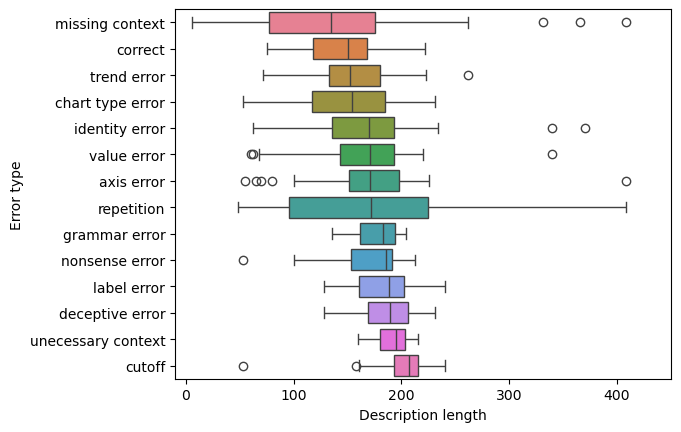

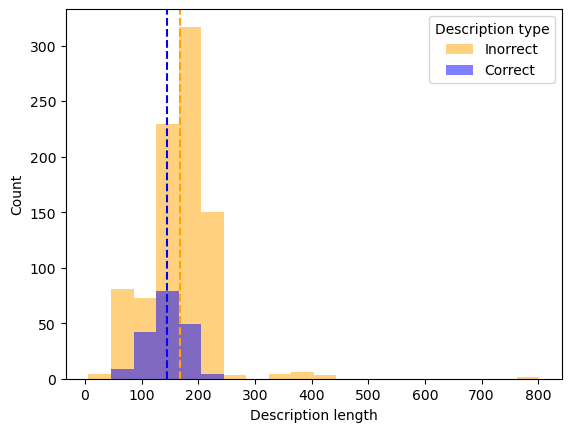

In [52]:
print(alt_lens_with_errs.keys())

err_median_lens = [np.median(al) for al in alt_lens_with_errs.values()]
sorted_median_idxs = np.argsort(err_median_lens)
sorted_err_lens = [list(alt_lens_with_errs.values())[i] for i in sorted_median_idxs]
sorted_err_names = [list(alt_lens_with_errs.keys())[i] for i in sorted_median_idxs]
sns.boxplot(sorted_err_lens, orient="h")
plt.gca().set_yticklabels(sorted_err_names)
plt.xlim((-10, 450))
plt.xlabel("Description length")
plt.ylabel("Error type")
plt.show()

correct_vals = []
incorrect_vals = []
for err_type, desc_lens in alt_lens_with_errs.items():
    if err_type == "correct":
        correct_vals.extend(desc_lens)
    else:
        incorrect_vals.extend(desc_lens)

(n, bins, patches) = plt.hist(incorrect_vals, bins=20, label="Inorrect", alpha=0.5, color="orange")
plt.axvline(x=np.mean(incorrect_vals), ls="dashed", color="orange")
plt.hist(correct_vals, bins=bins, label="Correct", alpha=0.5, color="blue")
plt.axvline(x=np.mean(correct_vals), ls="dashed", color="blue")
#plt.xlim((0, 300))
plt.ylabel("Count")
plt.xlabel("Description length")
plt.legend(title="Description type")
plt.show()

C:\Users\Kai\AppData\Local\Temp\ipykernel_14876\3238709212.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(sorted_err_names)


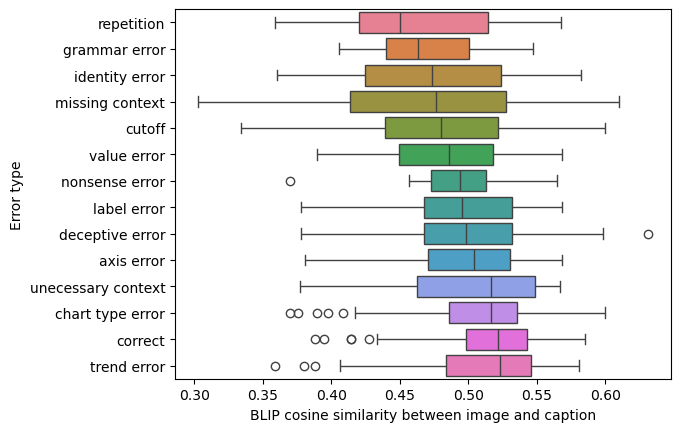

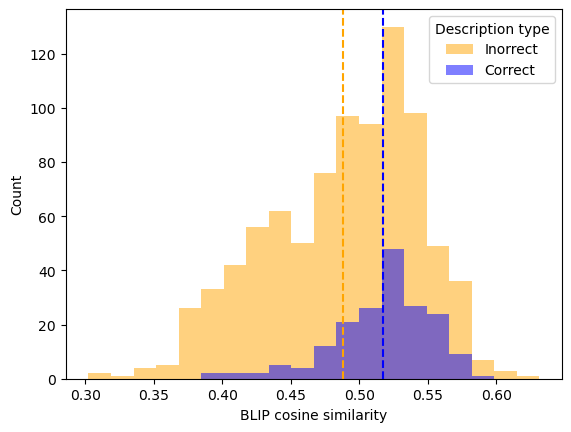

In [53]:
err_to_probs = {err_type: [bs["prob"] for bs in blipscores] for err_type, blipscores in alt_blipscores_with_errs.items()}
err_to_cos_sims = {err_type: [bs["cos-sim"] for bs in blipscores] for err_type, blipscores in alt_blipscores_with_errs.items()}

for err_to_val_dict in [err_to_cos_sims]:#, err_to_probs:
    err_medians = [np.median(al) for al in err_to_val_dict.values()]
    sorted_median_idxs = np.argsort(err_medians)
    sorted_err_vals = [list(err_to_val_dict.values())[i] for i in sorted_median_idxs]
    sorted_err_names = [list(err_to_val_dict.keys())[i] for i in sorted_median_idxs]
    sns.boxplot(sorted_err_vals, orient="h")
    plt.gca().set_yticklabels(sorted_err_names)
    #plt.xlim((-10, 450))
    plt.xlabel("BLIP cosine similarity between image and caption")
    plt.ylabel("Error type")
    plt.show()

    correct_vals = []
    incorrect_vals = []
    for err_type, desc_cos_sims in err_to_val_dict.items():
        if err_type == "correct":
            correct_vals.extend(desc_cos_sims)
        else:
            incorrect_vals.extend(desc_cos_sims)
    (n, bins, patches) = plt.hist(incorrect_vals, bins=20, label="Inorrect", alpha=0.5, color="orange")
    plt.axvline(x=np.mean(incorrect_vals), ls="dashed", color="orange")
    plt.hist(correct_vals, bins=bins, label="Correct", alpha=0.5, color="blue")
    plt.axvline(x=np.mean(correct_vals), ls="dashed", color="blue")
    plt.ylabel("Count")
    plt.xlabel("BLIP cosine similarity")
    plt.legend(title="Description type")
    plt.show()


C:\Users\Kai\AppData\Local\Temp\ipykernel_14876\1390077511.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(sorted_err_names)


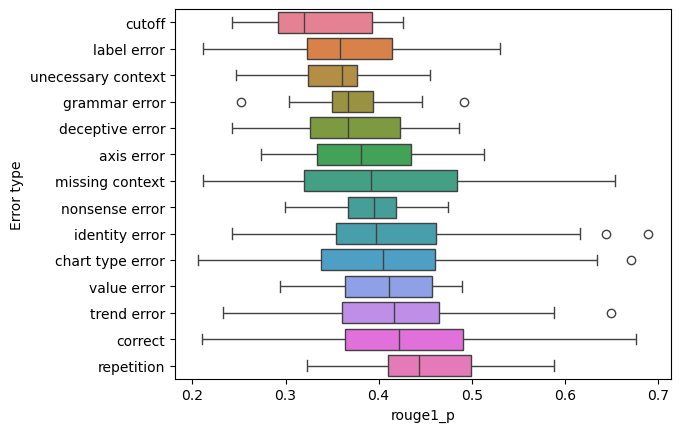

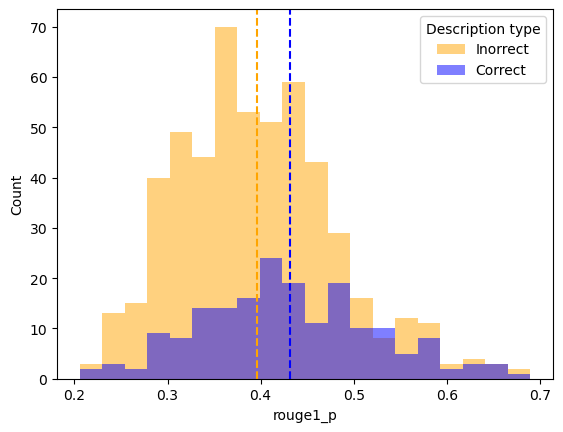

C:\Users\Kai\AppData\Local\Temp\ipykernel_14876\1390077511.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(sorted_err_names)


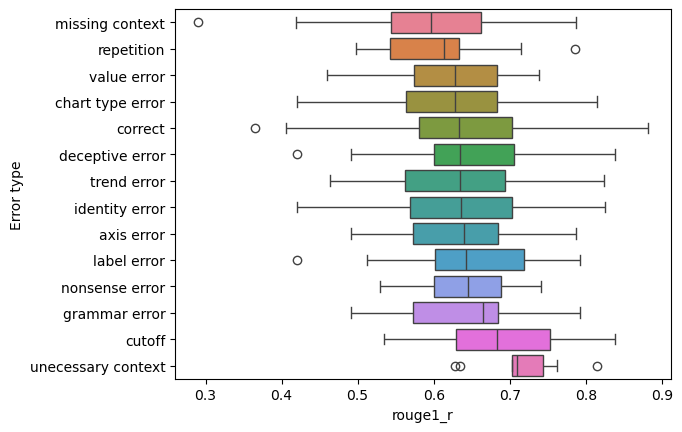

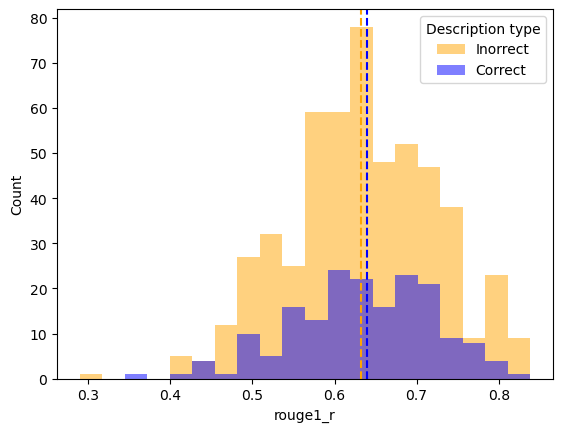

C:\Users\Kai\AppData\Local\Temp\ipykernel_14876\1390077511.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(sorted_err_names)


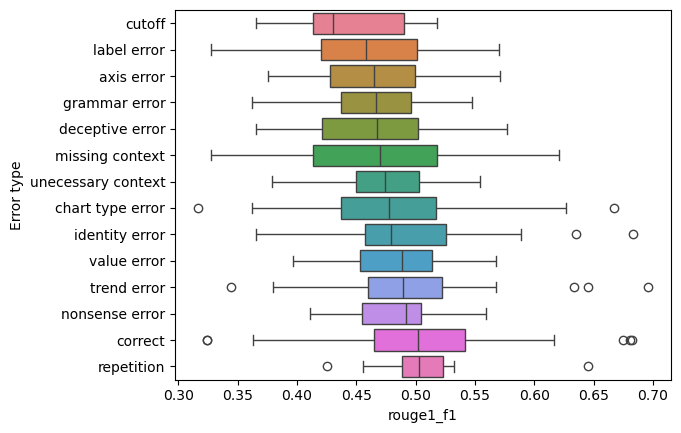

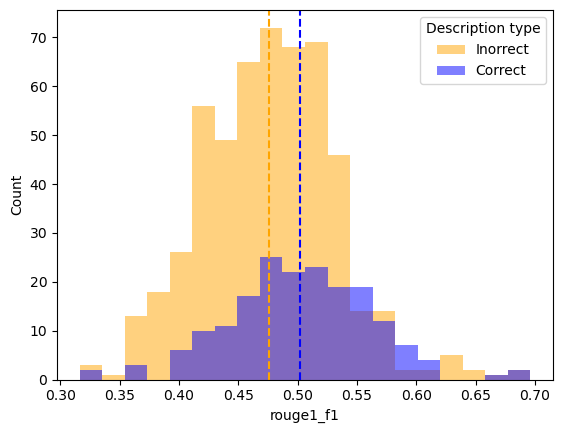

C:\Users\Kai\AppData\Local\Temp\ipykernel_14876\1390077511.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(sorted_err_names)


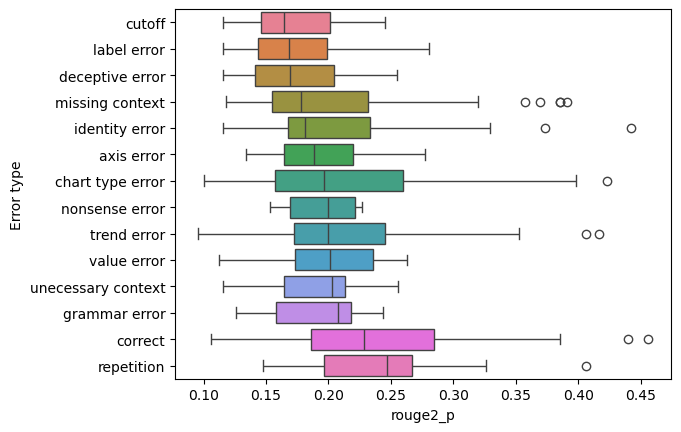

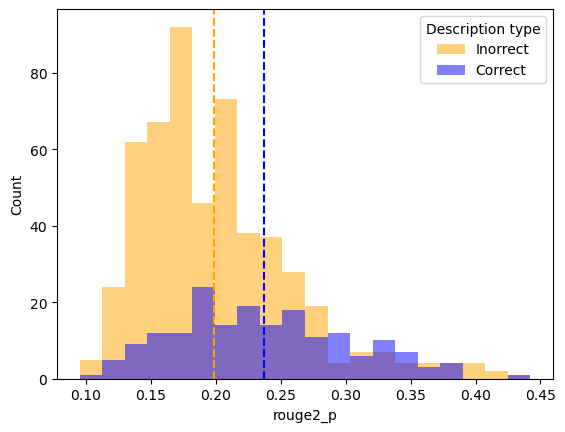

C:\Users\Kai\AppData\Local\Temp\ipykernel_14876\1390077511.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(sorted_err_names)


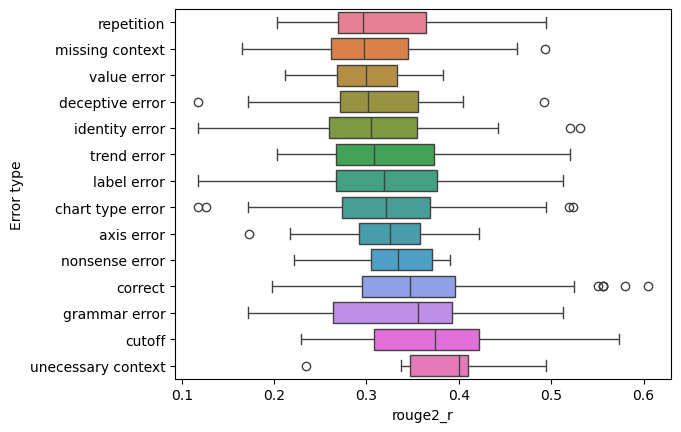

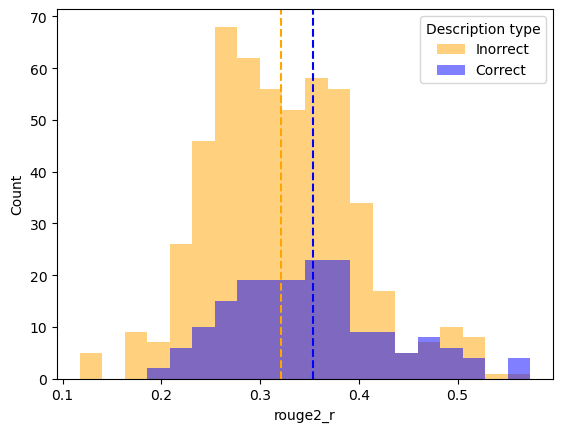

C:\Users\Kai\AppData\Local\Temp\ipykernel_14876\1390077511.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(sorted_err_names)


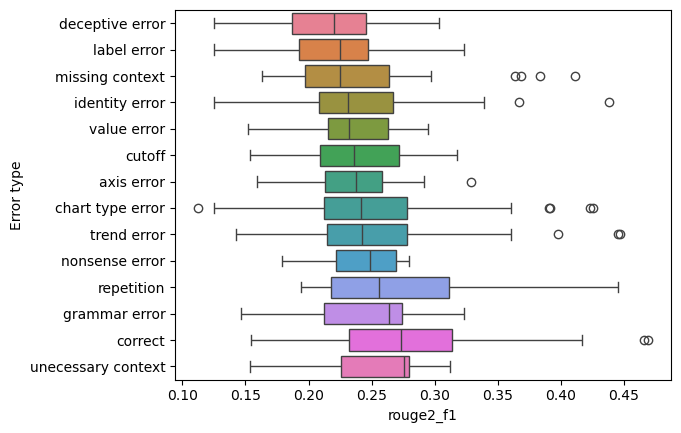

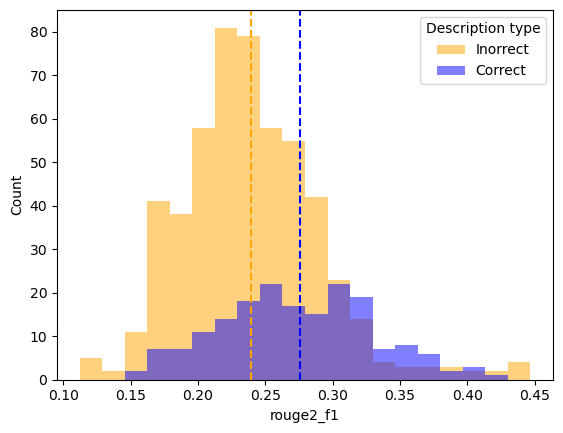

C:\Users\Kai\AppData\Local\Temp\ipykernel_14876\1390077511.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(sorted_err_names)


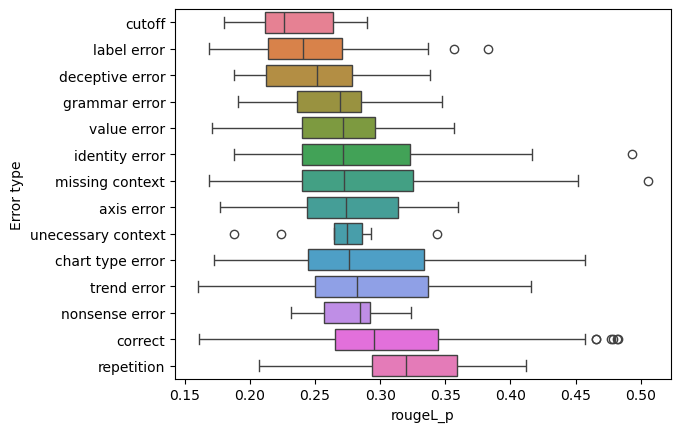

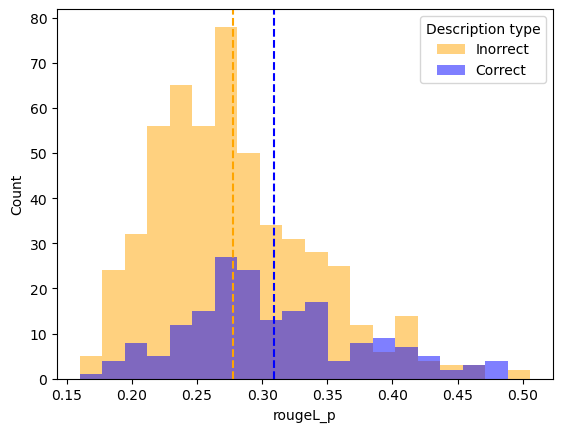

C:\Users\Kai\AppData\Local\Temp\ipykernel_14876\1390077511.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(sorted_err_names)


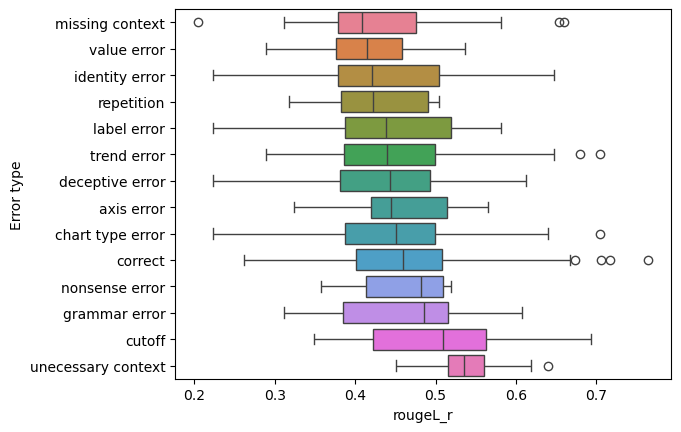

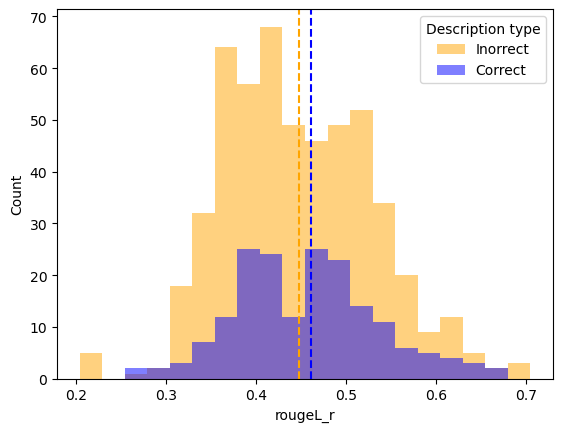

C:\Users\Kai\AppData\Local\Temp\ipykernel_14876\1390077511.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(sorted_err_names)


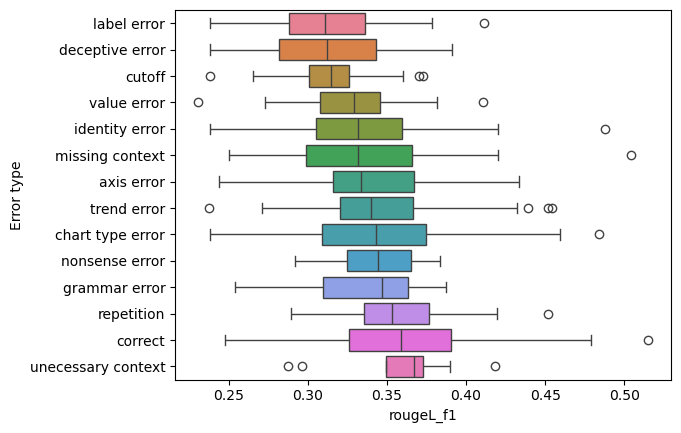

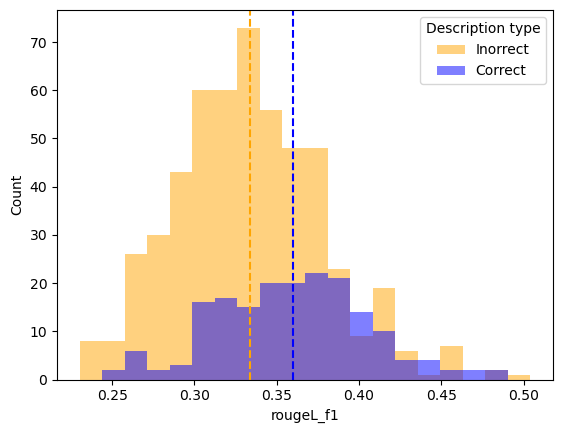

C:\Users\Kai\AppData\Local\Temp\ipykernel_14876\1390077511.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(sorted_err_names)


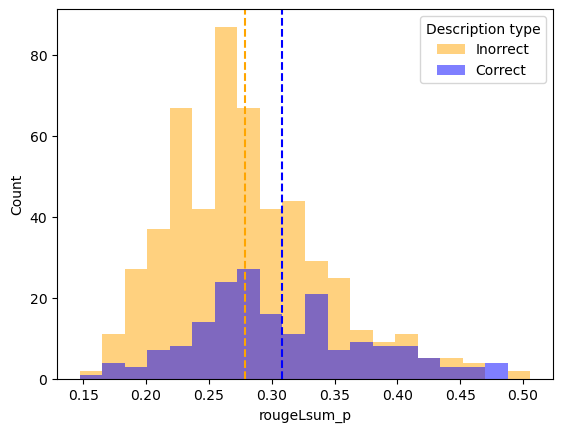

C:\Users\Kai\AppData\Local\Temp\ipykernel_14876\1390077511.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(sorted_err_names)


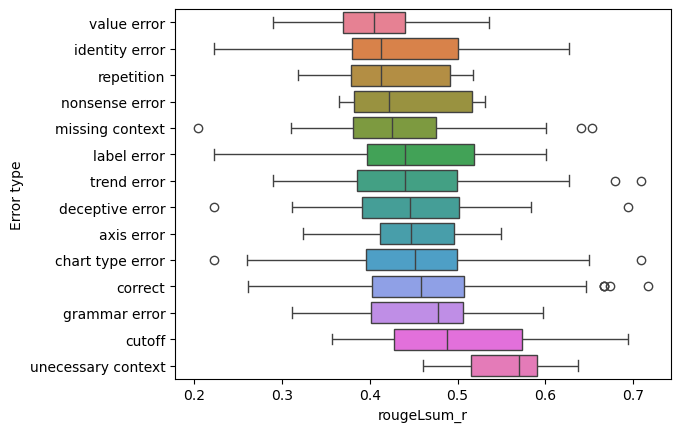

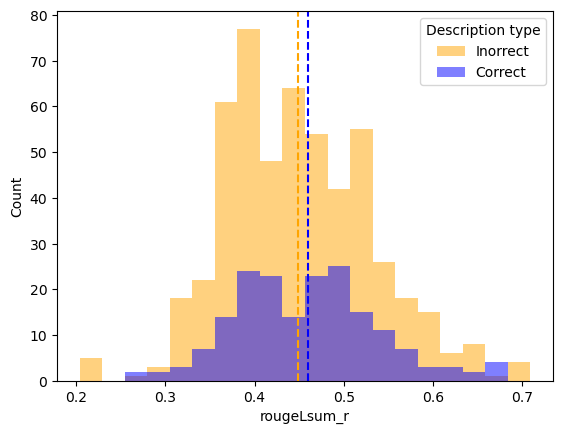

C:\Users\Kai\AppData\Local\Temp\ipykernel_14876\1390077511.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(sorted_err_names)


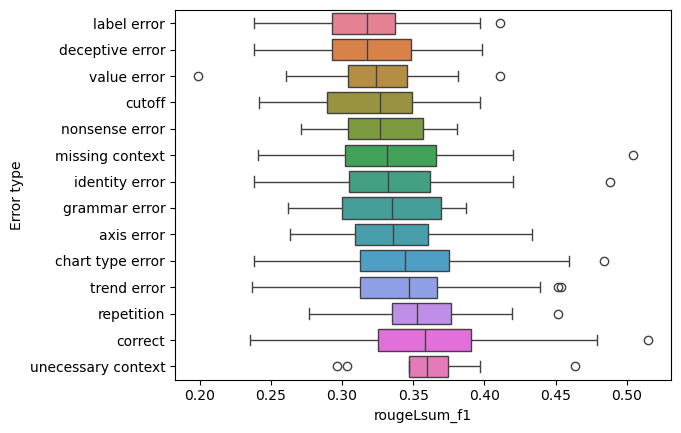

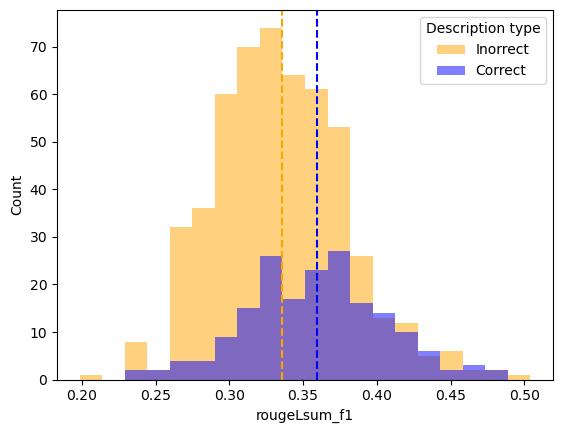

C:\Users\Kai\AppData\Local\Temp\ipykernel_14876\1390077511.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(sorted_err_names)


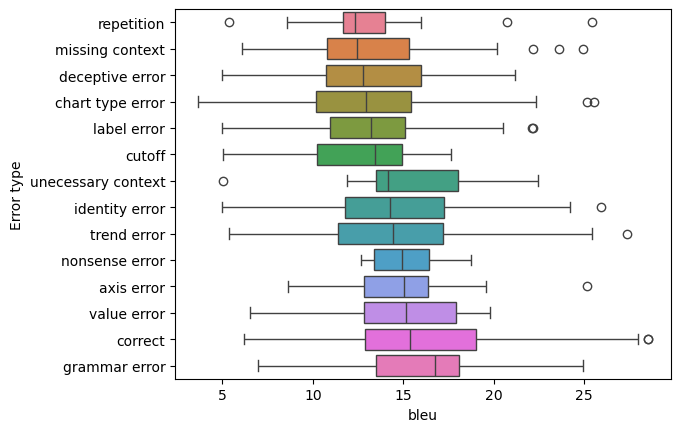

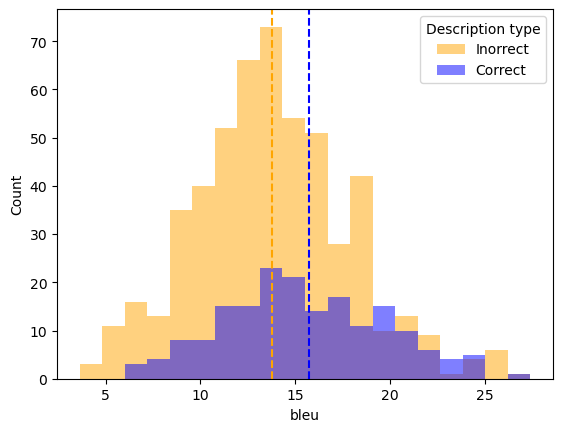

C:\Users\Kai\AppData\Local\Temp\ipykernel_14876\1390077511.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(sorted_err_names)


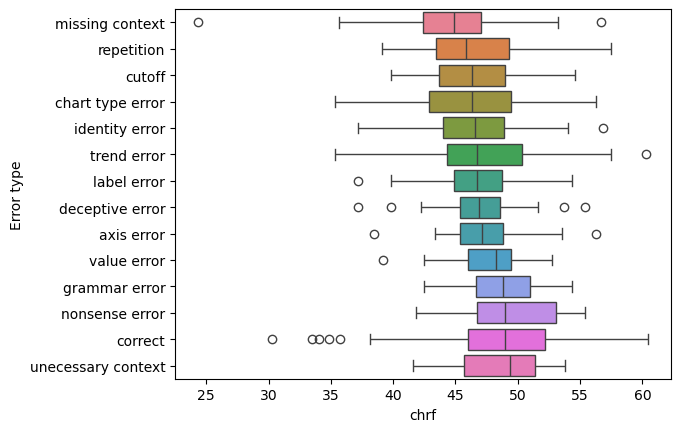

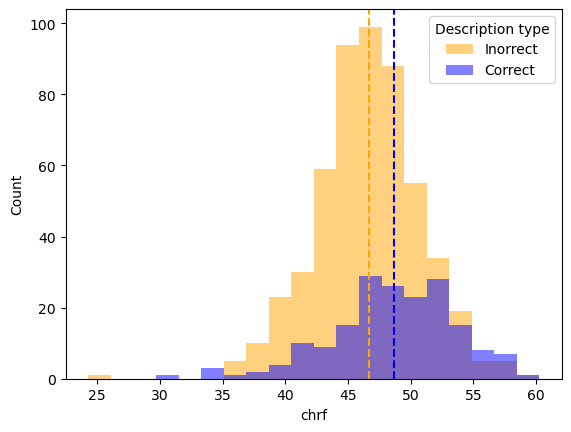

C:\Users\Kai\AppData\Local\Temp\ipykernel_14876\1390077511.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(sorted_err_names)


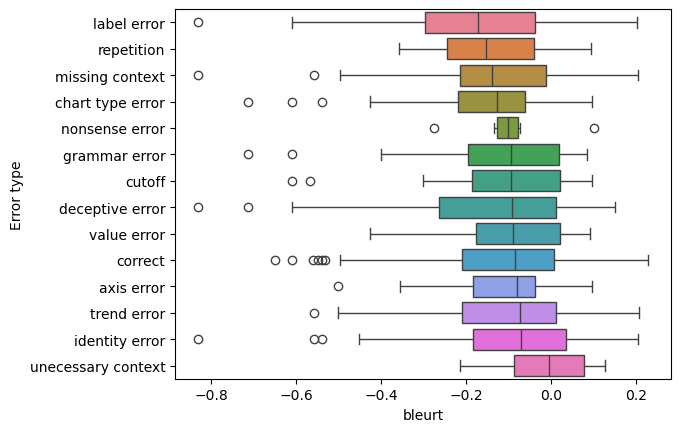

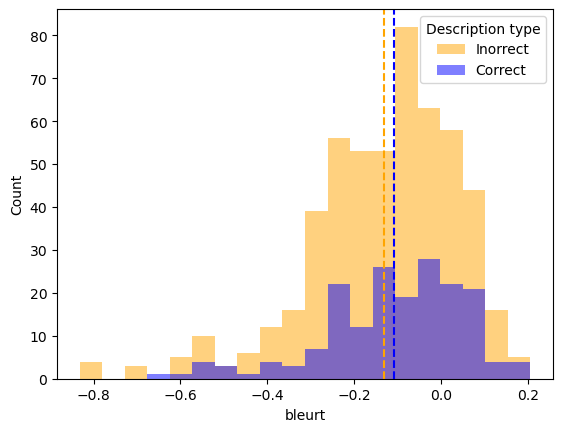

C:\Users\Kai\AppData\Local\Temp\ipykernel_14876\1390077511.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(sorted_err_names)


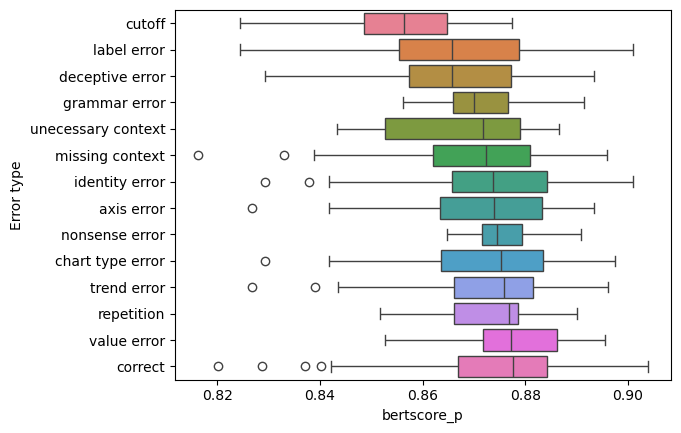

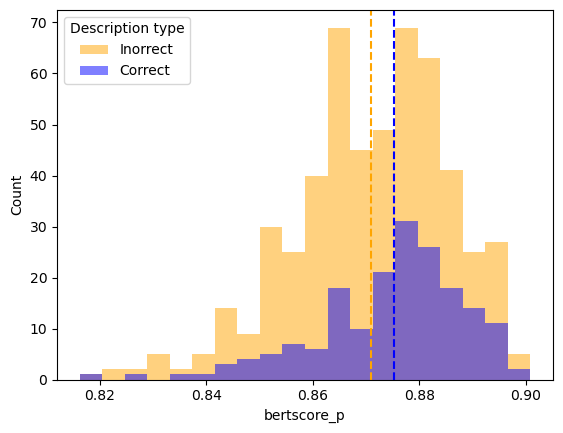

C:\Users\Kai\AppData\Local\Temp\ipykernel_14876\1390077511.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(sorted_err_names)


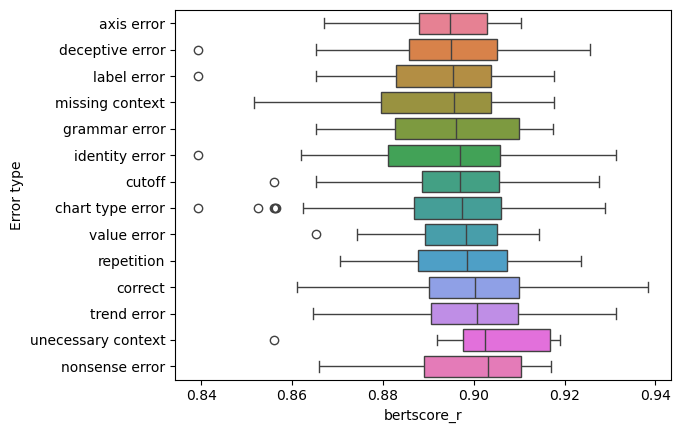

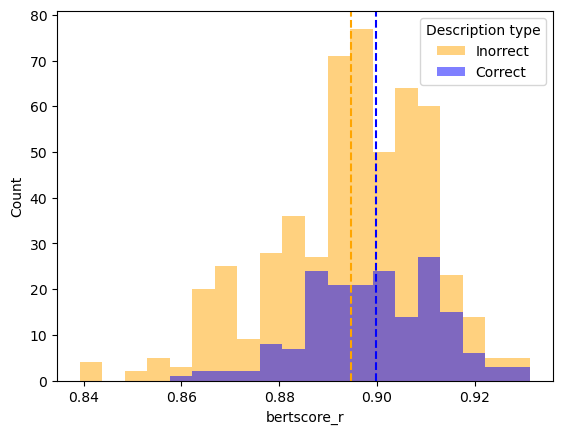

C:\Users\Kai\AppData\Local\Temp\ipykernel_14876\1390077511.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(sorted_err_names)


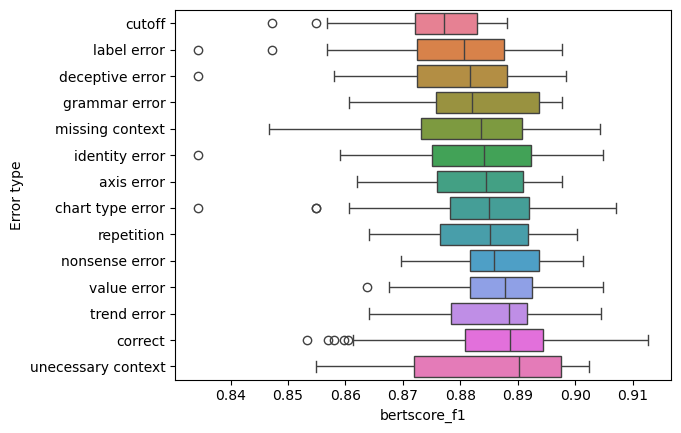

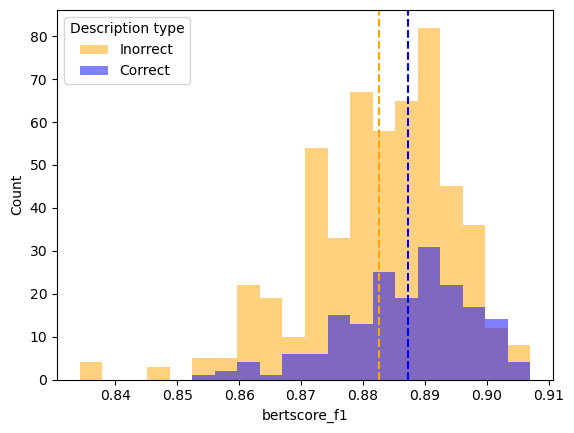

In [54]:
human_sim_metrics = list(alt_human_sims_with_errs["correct"][0].keys())
for sim_metric in human_sim_metrics:
    #for err_type, sim_scores in alt_human_sims_with_errs.items():
    #    print(sim_scores)
    #    print([np.mean(s[sim_metric]) for s in sim_scores])
    #    break
    #break
    err_to_sims_dict = {}
    correct_vals = []
    incorrect_vals = []
    for err_type, sim_scores in alt_human_sims_with_errs.items():
        metric_sim_scores = []
        for s in sim_scores:
            if isinstance(s, dict):
                metric_sim_scores.append(np.mean(s[sim_metric]))
                if err_type == "correct":
                    correct_vals.append(np.mean(s[sim_metric]))
                else:
                    incorrect_vals.append(np.mean(s[sim_metric]))
        err_to_sims_dict[err_type] = metric_sim_scores
    err_medians = [np.median(al) for al in err_to_sims_dict.values()]
    sorted_median_idxs = np.argsort(err_medians)
    sorted_err_vals = [list(err_to_sims_dict.values())[i] for i in sorted_median_idxs]
    sorted_err_names = [list(err_to_sims_dict.keys())[i] for i in sorted_median_idxs]
    sns.boxplot(sorted_err_vals, orient="h")
    plt.gca().set_yticklabels(sorted_err_names)
    #plt.xlim((-10, 450))
    plt.xlabel(sim_metric)
    plt.ylabel("Error type")
    plt.show()

    (n, bins, patches) = plt.hist(incorrect_vals, bins=20, label="Inorrect", alpha=0.5, color="orange")
    plt.axvline(x=np.mean(incorrect_vals), ls="dashed", color="orange")
    plt.hist(correct_vals, bins=bins, label="Correct", alpha=0.5, color="blue")
    plt.axvline(x=np.mean(correct_vals), ls="dashed", color="blue")
    plt.ylabel("Count")
    plt.xlabel(sim_metric)
    plt.legend(title="Description type")
    plt.show()
